<a href="https://colab.research.google.com/github/eswahn/northerngrounds/blob/main/Workshop_Text_guided_GAN_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-guided GAN generation with StyleGAN and CLIP for the Northern Grounds studio workshop

Based on https://github.com/orpatashnik/StyleCLIP

# Install

In [1]:
!git clone https://github.com/eswahn/StyleCLIP.git

import os
os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 42 (delta 10), reused 33 (delta 7), pack-reused 0
Unpacking objects: 100% (42/42), done.
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-cp36-none-any.whl size=46451 sha256=6933597449acbcd1e12c544aa81622fb3eba0344815ad855a0c65db5493a1a46
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1j3xwn73
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-1j3xwn73
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 48.1MB/s 
  Created wheel for clip: filename=clip-1.0-cp36-none-any.whl size=1368563 sha256=43e3c22a17b81746d0b4d7a082c50688b5cdc845

# Select a pre-trained model and output path

In [13]:
model_name = 'Isometric RGB latest' #@param ['Isometric RGB latest', 'Isometric RGB early', 'Isometric BW latest', 'Isometric BW early', 'Plan RGB latest', 'Plan RGB early', 'Plan BW latest', 'Plan BW early', 'Wikiart', 'FFHQ'] {type:"string"}

#@markdown Or specify a path to a pt model file:

pt_file_path = '' #@param {type:'string'}

# Load model

In [8]:
if pt_file_path == '':
  pt_file_path = 'network.pt'

  if model_name == 'Isometric RGB latest':
    !gdown --id 1vfbYJLYNlm2kZaqy4jEREq6D-0j2aO0O -O {pt_file_path}
  if model_name == 'Isometric RGB early':
    !gdown --id 18m4Dprmu-FcvdcLjOuiXLxji49zUuved -O {pt_file_path}
  if model_name == 'Isometric BW latest':
    !gdown --id 1dGQs0B1A8VvLsMXfcP2Q-LxHWpcZtgo8 -O {pt_file_path}
  if model_name == 'Isometric BW early':
    !gdown --id 1YU8en4_X-STKw622MJ6TYBKkCuA-b_Gy -O {pt_file_path}

  if model_name == 'Plan RGB latest':
    !gdown --id 1-1BNkogVPYhxFslHAYYEMq-jQOQYSJke -O {pt_file_path}
  if model_name == 'Plan RGB early':
    !gdown --id 1-0fNHDBBYUDJM2rpyCb-snVmg5DMiwqH -O {pt_file_path}
  if model_name == 'Plan BW latest':
    !gdown --id 1-1rhG7iTlo5269cUA8CNJ1wwI_o9GSv6 -O {pt_file_path}
  if model_name == 'Plan BW early':
    !gdown --id 1-1OhPnsRVDLV8hNT-Hhak8jBbYuzwqI6 -O {pt_file_path}

  if model_name == 'Wikiart':
    !gdown --id 1-3wu6-n4Wcm0mBauYBhvFHLAwJ3mTqea -O {pt_file_path}
  if model_name == 'FFHQ':
    !gdown --id 1-2fhe1iPMrYWhbSO1JWVMCLqmHcrn4Qx -O {pt_file_path}
else:
  !cp -a {pt_file_path} ./network.pt

Downloading...
From: https://drive.google.com/uc?id=1-3wu6-n4Wcm0mBauYBhvFHLAwJ3mTqea
To: /content/StyleCLIP/network.pt
124MB [00:01, 71.3MB/s]


# Text-guided editing or generation

In [10]:
experiment_type = 'free_generation' #@param ['edit', 'free_generation']

description = 'A cathedral on a lake' #@param {type:"string"}

latent_path = None #@param {type:"string"}

optimization_steps =  50#@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

create_video = True #@param {type:"boolean"}

args = {
    "description": description,
    "ckpt": "network.pt",
    "size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.06,
    "step": optimization_steps,
    "mode": experiment_type,
    "l2_lambda": l2_lambda,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results"
}

In [11]:
from main import main
from argparse import Namespace
result = main(Namespace(**args))

loss: 0.6025;: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


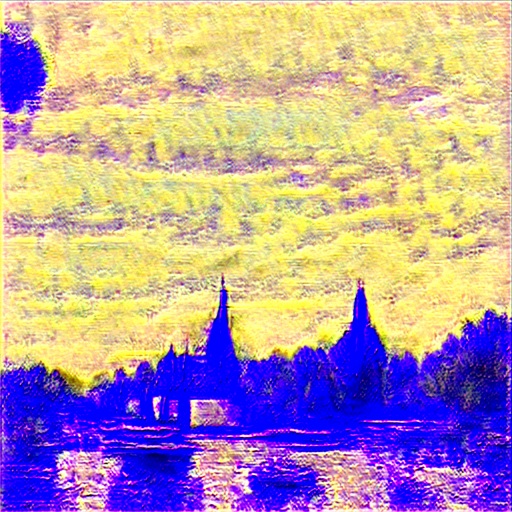

In [12]:
#@title Visualize Result
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
#@title Create and Download Video

!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
from google.colab import files
files.download('out.mp4')